In [1]:
endpoint = 'https://synbiohub.org/sparql?'

query = '''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX sbh: <http://wiki.synbiohub.org/wiki/Terms/synbiohub#>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX sbol: <http://sbols.org/v2#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX purl: <http://purl.obolibrary.org/obo/>

select ?s ?o where {
?s a sbol:ComponentDefinition .
?s sbol:sequence ?seq .
?seq a sbol:Sequence .
?seq sbol:elements ?o .
}
'''

In [2]:
import requests
import urllib.parse

url = endpoint + urllib.parse.urlencode({'query': query})
print(url)
r = requests.get(url)

print(r.status_code)
print(r.encoding)
print(r.headers['content-type'])
print(r.content[0:1000])

f = open('response.xml', 'w')
f.write(r.content.decode('utf8'))

https://synbiohub.org/sparql?query=%0APREFIX+rdf%3A+%3Chttp%3A%2F%2Fwww.w3.org%2F1999%2F02%2F22-rdf-syntax-ns%23%3E%0APREFIX+dcterms%3A+%3Chttp%3A%2F%2Fpurl.org%2Fdc%2Fterms%2F%3E%0APREFIX+dc%3A+%3Chttp%3A%2F%2Fpurl.org%2Fdc%2Felements%2F1.1%2F%3E%0APREFIX+sbh%3A+%3Chttp%3A%2F%2Fwiki.synbiohub.org%2Fwiki%2FTerms%2Fsynbiohub%23%3E%0APREFIX+prov%3A+%3Chttp%3A%2F%2Fwww.w3.org%2Fns%2Fprov%23%3E%0APREFIX+sbol%3A+%3Chttp%3A%2F%2Fsbols.org%2Fv2%23%3E%0APREFIX+xsd%3A+%3Chttp%3A%2F%2Fwww.w3.org%2F2001%2FXMLSchema%23%3E%0APREFIX+rdfs%3A+%3Chttp%3A%2F%2Fwww.w3.org%2F2000%2F01%2Frdf-schema%23%3E%0APREFIX+purl%3A+%3Chttp%3A%2F%2Fpurl.obolibrary.org%2Fobo%2F%3E%0A%0Aselect+%3Fs+%3Fo+where+%7B%0A%3Fs+a+sbol%3AComponentDefinition+.%0A%3Fs+sbol%3Asequence+%3Fseq+.%0A%3Fseq+a+sbol%3ASequence+.%0A%3Fseq+sbol%3Aelements+%3Fo+.%0A%7D%0A
200
utf-8
application/sparql-results+xml; charset=utf-8
b'<sparql xmlns="http://www.w3.org/2005/sparql-results#" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:s

65385932

In [4]:
f = open('response.xml', 'r')
content = f.read()

In [5]:
from xml.etree import ElementTree


def create_sequences(xml_content):
    sequences = {}
    
    ns = {'sparql_results': 'http://www.w3.org/2005/sparql-results#'}
    
    root = ElementTree.fromstring(xml_content)
    results = root.find('sparql_results:results', ns)

    for result in results.findall('sparql_results:result', ns):
        bindings = result.findall('sparql_results:binding', ns)

        for binding in bindings:
            if binding.attrib['name'] == 's':
                uri = binding.find('sparql_results:uri', ns).text

        for binding in bindings:
            if binding.attrib['name'] == 'o':
                sequence = binding.find('sparql_results:literal', ns).text

        sequences[uri] = sequence
    
    return sequences


sequences = create_sequences(content)

In [6]:
def write_fasta(sequences):
    f = open('synbiohub.fsa', 'w')
    
    for uri in sequences.keys():
        f.write('>%s\n' % uri)
        f.write('%s\n' % sequences[uri])
    
    f.close()
    
    
write_fasta(sequences)

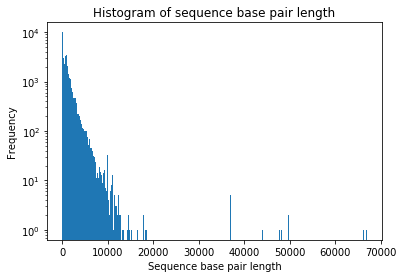

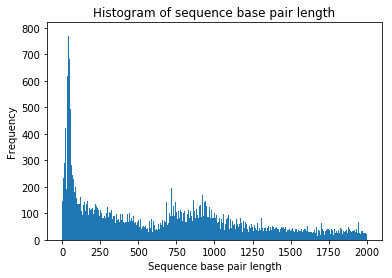

In [16]:
import matplotlib.pyplot as plt

def plot_sequence_lengths(sequences, logy=False, bins=500, cutoff=None):
    base_lengths = []
    
    for uri in sequences.keys():
        length = len(sequences[uri])
        
        if cutoff is None or length < cutoff:
            base_lengths.append(length)
    
    plt.hist(base_lengths, bins)
    if logy:
        plt.yscale('log', nonposy='clip')
        
    _ = plt.title('Histogram of sequence base pair length')
    _ = plt.xlabel('Sequence base pair length')
    _ = plt.ylabel('Frequency')
    plt.show()

plot_sequence_lengths(sequences, logy=True, bins=500)
plot_sequence_lengths(sequences, logy=False, bins=500, cutoff=2000)

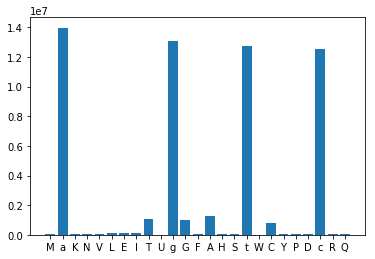

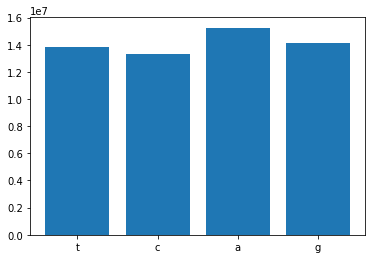

In [9]:
import matplotlib.pyplot as plt


def get_base_frequencies(sequences):
    base_frequencies = {}
    
    for uri, sequence in sequences.items():
        for base in sequence:
            if base not in base_frequencies:
                base_frequencies[base] = 0
            base_frequencies[base] += 1
    
    return base_frequencies


def plot_base_frequencies(base_frequencies):
    plt.bar(range(len(base_frequencies)), list(base_frequencies.values()), align='center')
    plt.xticks(range(len(base_frequencies)), list(base_frequencies.keys()))
    plt.show()

    
def normalize_sequences(sequences, approved_bases):
    for uri in sequences.keys():
        lowered = sequences[uri].lower()
        stripped = ''.join(c for c in lowered if c in approved_bases)
        sequences[uri] = stripped
        
    
base_frequencies = get_base_frequencies(sequences)
plot_base_frequencies(base_frequencies)

normalize_sequences(sequences, {'g', 'a', 't', 'c'})
base_frequencies = get_base_frequencies(sequences)
plot_base_frequencies(base_frequencies)